# Machine Learning Pipeline End to End Solution

## Introduction

Le fichier "data.csv" contient plus de 160.000 chanson collecté à partir de l'API web de SPotify. Le dataset de Spotify contient 169k titres de l'année 1921 à l'année 1920.

Le fichier peut être téléchargé sur lien suivant: https://www.kaggle.com/ektanegi/spotifydata-19212020

## Preparation

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/DM2/"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


['data.csv']

install pyspark and findspark

In [ ]:
!pip install -q pyspark
!pip install -q findspark

Start the Spark session

In [ ]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [ ]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1636621079308


In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


## Data loading

In [ ]:
df = spark.read\
            .format("csv").option("header", "true")\
            .option("inferSchema", "true")\
            .load(drive_dir +"data.csv")

In [ ]:
df.printSchema()

root
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- year: string (nullable = true)



In [ ]:
                #.withColumn("acousticness", df("acousticness").cast("double"))
                #.withColumn("artists", df("artists").cast("double"))
                #.withColumn("id", df("id").cast("string"))
                #.withColumn("name", df("name").cast("string"))
                #.withColumn("release_date", df("release_date").cast("integer"))

In [ ]:
spotify_df = df.withColumn("danceability", df["danceability"].cast("double"))\
                .withColumn("duration_ms", df["duration_ms"].cast("integer"))\
                .withColumn("energy", df["energy"].cast("double"))\
                .withColumn("explicit", df["explicit"].cast("integer"))\
                .withColumn("instrumentalness", df["instrumentalness"].cast("double"))\
                .withColumn("key", df["key"].cast("integer"))\
                .withColumn("liveness", df["liveness"].cast("double"))\
                .withColumn("loudness", df["loudness"].cast("double"))\
                .withColumn("mode", df["mode"].cast("integer"))\
                .withColumn("popularity", df["popularity"].cast("integer"))\
                .withColumn("speechiness", df["speechiness"].cast("double"))\
                .withColumn("tempo", df["tempo"].cast("double"))\
                .withColumn("valence", df["valence"].cast("double"))\
                .withColumn("year", df["year"].cast("integer"))

In [ ]:
spotify_df.count()

169909

In [ ]:
spotify_df.show()

+------------+--------------------+------------------+-----------+-------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+--------------------+-----------------+-------------------+----+
|acousticness|             artists|      danceability|duration_ms| energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|         speechiness|            tempo|            valence|year|
+------------+--------------------+------------------+-----------+-------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+--------------------+-----------------+-------------------+----+
|       0.995| ['Carl Woitschach']|             0.708|     158648|  0.195|       0|6KbQ3uYMLKb5jDxLF...|           0.563| 10|   0.151|            -12.428|   1|Singende Bataillo...|         0|  

Ce jeu de données comprend 19 attributs allant de la date de sortie du morceau, à sa durée, au mode ou encore sa "danceability". Certains de ces attributs seront donc des chaînes de caractères comme par exemple le nom d'un artiste ou encore l'id du titre, et d'autres auront donc des valeurs numériques comme la "liveness" ou l'"acousticness".

La variable que je souhaite prédire au cours de ce projet est celle de la danceability". En effet, je souhaiterai savoir s'il possible de prédire à partir de toutes les autres caractéristiques d'un morceau, si ce dernier est un morceau qui nous amène à danser facilement.

Tout comme les attributs "energy", "liveness", "speechiness", "acousticness", "instrumentalness" et "valence", l'attribut "danceability" prend ses valeurs entre 0 et 1, plus la valeur est proche de 1 plus le titre en question nous fait danser facilement.

Les autres attributs numériques sont :

    duration_ms : un entier qui prend habituellement ses valeurs entre 200 000 et 300 000
    popularity : un entier qui prend ses valeurs entre 0 et 100
    tempo : un flottant qui prend ses valeurs entre 0 et 250
    loudness : un flottant entre - 60 et 0
    year : un entier entre 1921 et 2020
    mode : un entier qui vaut soit 0 ou 1, 0 pour Minor, 1 pour Major
    explicit : un entier qui vaut soit 0 ou 1, 0 pour un titre avec un contenu non explicite, 1 sinon

Les attributs qui prennent des valeurs textuelles sont :

    artists : la liste des artistes d'un morceau
    name : le titre
    release_date : la date de sortie usuellement de la forme yyyy-mm-dd
    key : le semi ton d'un octave encodée entre 0 et 11, en commençant à 0 avec le semi-ton C



## Stratégie de filtration de la data
On va faire ici faire la stratégie qui consiste à trier et filtrer les données. On va donc identifier les données manquantes et aberrantes pour les enlever de notre étude.


In [ ]:
from pyspark.sql import DataFrameNaFunctions as dfna

In [ ]:
acousticsness = spotify_df.where("acousticness is NULL")
acousticsness.count()

0

In [ ]:
artists = spotify_df.where("artists is NULL")
artists.count()

0

In [ ]:
danceability = spotify_df.where("danceability is NULL")
danceability.count()

594

In [ ]:
duration_ms = spotify_df.where("duration_ms is NULL")
duration_ms.count()

203

In [ ]:
energy = spotify_df.where("energy is NULL")
energy.count()

85

In [ ]:
explicit = spotify_df.where("explicit is NULL")
explicit.count()

49

In [ ]:
id = spotify_df.where("id is NULL")
id.count()

0

In [ ]:
instrumentalness = spotify_df.where("instrumentalness is NULL")
instrumentalness.count()

400

In [ ]:
key = spotify_df.where("key is NULL")
key.count()

209

In [ ]:
liveness = spotify_df.where("liveness is NULL")
liveness.count()

43

In [ ]:
loudness = spotify_df.where("loudness is NULL")
loudness.count()

32

In [ ]:
mode = spotify_df.where("mode is NULL")
mode.count()

20

In [ ]:
popularity = spotify_df.where("popularity is NULL")
popularity.count()

1247

In [ ]:
release_date = spotify_df.where("release_date is NULL")
release_date.count()

0

In [ ]:
speechiness = spotify_df.where("speechiness is NULL")
speechiness.count()

647

In [ ]:
tempo = spotify_df.where("tempo is NULL")
tempo.count()

265

In [ ]:
valence = spotify_df.where("valence is NULL")
valence.count()

130

In [ ]:
year = spotify_df.where("year is NULL")
year.count()

63

In [ ]:
missing = spotify_df.exceptAll(spotify_df.na.drop())
missing.count()

1447

• Identifier les valeurs aberrantes en fonction de votre dataset, s'il y en a

In [ ]:
spotify_df.describe("acousticness").show()

+-------+-------------------+
|summary|       acousticness|
+-------+-------------------+
|  count|             169909|
|   mean|  0.493213976149875|
| stddev|0.37662706233783233|
|    min|                0.0|
|    max|              0.996|
+-------+-------------------+



In [ ]:
spotify_df.describe("artists").show()

+-------+--------------------+
|summary|             artists|
+-------+--------------------+
|  count|              169909|
|   mean|                null|
| stddev|                null|
|    min|"[""'In The Heigh...|
|    max|            ['黑豹']|
+-------+--------------------+



In [ ]:
spotify_df.describe("danceability").show()

+-------+-------------------+
|summary|       danceability|
+-------+-------------------+
|  count|             169315|
|   mean| 0.5383963718512802|
| stddev|0.17516340789732873|
|    min|                0.0|
|    max|              0.988|
+-------+-------------------+



In [ ]:
spotify_df.describe("duration_ms").show()

+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|            169706|
|   mean|230836.68061235314|
| stddev|121598.38001447188|
|    min|                 0|
|    max|           5403500|
+-------+------------------+



In [ ]:
spotify_df.describe("energy").show()

+-------+------------------+
|summary|            energy|
+-------+------------------+
|  count|            169824|
|   mean| 563.0004471781228|
| stddev|13873.071688291346|
|    min|               0.0|
|    max|         1622000.0|
+-------+------------------+



In [ ]:
spotify_df.describe("explicit").show()

+-------+------------------+
|summary|          explicit|
+-------+------------------+
|  count|            169860|
|   mean|161.00533380430943|
| stddev| 6951.694290656189|
|    min|                 0|
|    max|            693933|
+-------+------------------+



In [ ]:
spotify_df.describe("id").show()

+-------+--------------------+
|summary|                  id|
+-------+--------------------+
|  count|              169909|
|   mean|  15120.043013350787|
| stddev|   63446.14364146963|
|    min| ""Orchestra Sinf...|
|    max|7zzuPsjj9L3M7ikqG...|
+-------+--------------------+



In [ ]:
spotify_df.describe("instrumentalness").show()

+-------+------------------+
|summary|  instrumentalness|
+-------+------------------+
|  count|            169509|
|   mean| 34.66554720340806|
| stddev|2947.0441377717502|
|    min|               0.0|
|    max|          442387.0|
+-------+------------------+



In [ ]:
spotify_df.describe("key").show()

+-------+------------------+
|summary|               key|
+-------+------------------+
|  count|            169700|
|   mean|23.401909251620506|
| stddev| 2365.103557319947|
|    min|                 0|
|    max|            503320|
+-------+------------------+



In [ ]:
spotify_df.describe("liveness").show()

+-------+------------------+
|summary|          liveness|
+-------+------------------+
|  count|            169866|
|   mean|3.5915371043060698|
| stddev| 983.4890494089746|
|    min|               0.0|
|    max|          290627.0|
+-------+------------------+



In [ ]:
spotify_df.describe("loudness").show()

+-------+-------------------+
|summary|           loudness|
+-------+-------------------+
|  count|             169877|
|   mean|-11.317750214006457|
| stddev|  5.698856397377892|
|    min|              -60.0|
|    max|               11.0|
+-------+-------------------+



In [ ]:
spotify_df.describe("mode").show()

+-------+------------------+
|summary|              mode|
+-------+------------------+
|  count|            169889|
|   mean| 7.412251528939484|
| stddev|1871.4441328526868|
|    min|               -36|
|    max|            701187|
+-------+------------------+



In [ ]:
spotify_df.describe("name").show()

+-------+----------------------------+
|summary|                        name|
+-------+----------------------------+
|  count|                      169909|
|   mean|                    Infinity|
| stddev|                         NaN|
|    min|               'Eric Church'|
|    max|화려하지 않은 고백 Confes...|
+-------+----------------------------+



In [ ]:
spotify_df.describe("popularity").show()

+-------+------------------+
|summary|        popularity|
+-------+------------------+
|  count|            168662|
|   mean| 31.69329190926231|
| stddev|21.544673090116472|
|    min|               -35|
|    max|               100|
+-------+------------------+



In [ ]:
spotify_df.describe("release_date").show()

+-------+--------------------+
|summary|        release_date|
+-------+--------------------+
|  count|              169909|
|   mean|  1928.5917610786885|
| stddev|   261.3359852321662|
|    min| ""L'amour est un...|
|    max|  Whipped into Shape|
+-------+--------------------+



In [ ]:
spotify_df.describe("speechiness").show()

+-------+------------------+
|summary|       speechiness|
+-------+------------------+
|  count|            169262|
|   mean| 5.529730555417152|
| stddev|102.68936018476819|
|    min|           -30.073|
|    max|            2009.0|
+-------+------------------+



In [ ]:
spotify_df.describe("tempo").show()

+-------+-----------------+
|summary|            tempo|
+-------+-----------------+
|  count|           169644|
|   mean|118.4264933720031|
| stddev|69.04922087046117|
|    min|           -8.331|
|    max|           2004.0|
+-------+-----------------+



In [ ]:
spotify_df.describe("valence").show()

+-------+------------------+
|summary|           valence|
+-------+------------------+
|  count|            169779|
|   mean| 5.467456964884345|
| stddev|1308.4772282000247|
|    min|               0.0|
|    max|          538760.0|
+-------+------------------+



In [ ]:
spotify_df.describe("year").show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|            169846|
|   mean| 1962.209542762267|
| stddev|173.41063696205933|
|    min|               -10|
|    max|              2020|
+-------+------------------+



Grâce aux analyses précédentes, j'ai pu déterminé qu'il y avait seulement 1447 données manquantes parmi les 169 909 lignes. Cela ne représente même pas 1% des données donc au lieu de remplacer par exemple les valeurs manquantes par la moyenne de la catégorie en question, j'ai décidé de simplement les enlever de mon jeu de données.

De plus, mes données ne comportent pas de valeurs aberrantes à proprement parler. Concernant l'attribut loudness, il est censé prendre ses valeurs entre -60 et 0 d'après les informations de la page kaggle, mais son maximum est de 11, je vais donc remplacer les valeurs supérieures à 0 par 0.


In [ ]:
spotify = spotify_df.na.drop().withColumn("loudness", when(spotify_df.loudness <= 0, spotify_df.loudness).otherwise(0))
spotify.count()

168462

L'attribut id comporte des valeurs distinctes qui n'apparaissent pas plusieurs fois dans le jeu de données, c'est pourquoi il me semble pertinent de l'exclure pour les futures expérimentations. Il faut également exclure l'attribut name pour la même raison. Il en est de même, avec release_date qui comporte trop de valeurs différentes, pour la date il vaut donc mieux se concentrer sur l'année de sortie, attribut year.

Concernant les attributs qui me semblent au contraire pertinenent d'inclure, mon choix se porte en premier lieu sur la popularity. En effet, certains tubes commerciaux sont faits justement pour danser, il faut donc selon moi l'inclure. De plus, les mesures présentes dans le jeu de données jouent également un rôle dans le fait que le morceau soit dansable. Ces mesures sont : acousticness, energy, instrumentalness, valence, tempo, liveness, loudness et speechiness.

Le nom des artistes d'un morceau, attribut artists, est également à prendre en compte selon moi, car la plupart artistes produisent des titres dans le même genre musical, donc s'ils ont déjà produits un titre qui a une forte danceability il y aura plus de chances que ce soit le cas pour leurs prochains morceaux.

Le semi-ton d'un morceau, attribut key me semble important quant au fait que le morceau soit dansable.

Concernant les trois attributs restants mode, explicit et duration_ms, je n'ai pas trop d'avis sur le fait qu'ils aient une influence sur la danceability du titre. Cela sera à tester dans la tâche 3 avec la cross-validation.


Les valeurs qui donnent lieu à des features continues sont : duration_ms, tempo, loudness, energy, liveness, speechiness, acousticness, instrumentalness, valence et danceability.

Celles qui au contraire donnent lieu à des features catégoriques sont : popularity, year, mode, explicit, artists, name, release_date, key et id. Ces 5 derniers attributs seront indexés par des StringIndexer car ce sont des chaînes de caractères, les 4 autres n'auront quant à eux pas besoin d'être indexés, il suffiera de fixer le nombre de catégories à une valeur supérieure au nombre des différentes 'classes' possibles pour ces attributs.

Cependant, comme dit auparavant il est inutile de travailler sur les attributs id et name car ces derniers possèdent autant de valeurs distinctes que de lignes parmi nos données. Ces deux attributs sont par conséquent exclus, au même titre que release_date. Le seul attribut que je vais indexer à l'aide de StringIndexer est donc artists.

Toutefois, en réalité je ne peux pas utiliser l'attribut artists car il possède trop de valeurs distinctes différentes par rapport aux autres attributs numériques. Par conséquent, si je change le maxCategories à la valeur du nombre d'artists distincts, cela va traiter l'attribut mettre le nom comme un attribut qui a des valeurs catégoricielles alors que ce n'est pas le cas. Et inversement, si je mets une valeur plus basse que celle du nombre d'artists distincts, cela va traiter l'attribut artists comme s'il avait des valeurs continues alors que ce n'est pas le cas.


In [ ]:
data = spotify.exceptAll(missing).withColumn("label", col("danceability")).drop(col("danceability"))

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer

In [ ]:
features = ["duration_ms", "tempo", "loudness", "energy", "liveness", "speechiness", "acousticness", "instrumentalness", "valence", "popularity", "year", "mode", "explicit"]
#assemble with the rest of the features
vecAssemb = VectorAssembler()\
        .setInputCols(features)\
        .setOutputCol("assembled")

MaxCategories est égal à 100 car je prends la plus grande valeur d'attributs distincts parmi les attributs catégoriciels que j'ai gardé soit :

    popularity : 100 valeurs distinctes différentes
    year : 100 valeurs distinctes différentes
    mode : 2 valeurs distinctes différentes
    explicit : 2 valeurs distinctes différentes
    key : 12 valeurs distinctes différentes



In [ ]:
data.select("popularity").distinct().count()

100

In [ ]:
vecIndexer = VectorIndexer()\
                .setInputCol(vecAssemb.getOutputCol())\
                .setOutputCol("features")\
                .setMaxCategories(100)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressionModel
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import IndexToString

In [ ]:
pipeline = Pipeline().setStages([vecAssemb,vecIndexer])
transformed_data = pipeline.fit(data).transform(data).select("features","label")
trainingData, testData = transformed_data.randomSplit([0.7, 0.3])

In [ ]:
dt = DecisionTreeRegressor()\
  .setLabelCol("label")\
  .setFeaturesCol("features")\
  .setMaxBins(100)

In [ ]:
dtModel = dt.fit(trainingData)
print("Learn decision tree regressor model:\n {}".format(dtModel.toDebugString))

Learn decision tree regressor model:
 DecisionTreeRegressionModel: uid=DecisionTreeRegressor_eccb73ad728c, depth=5, numNodes=63, numFeatures=13
  If (feature 8 <= 0.3775)
   If (feature 8 <= 0.1315)
    If (feature 2 <= -11.501999999999999)
     If (feature 8 <= 0.0603)
      If (feature 1 <= 92.1855)
       Predict: 0.17822659846547312
      Else (feature 1 > 92.1855)
       Predict: 0.2598317914213626
     Else (feature 8 > 0.0603)
      If (feature 1 <= 94.9025)
       Predict: 0.2763129857819906
      Else (feature 1 > 94.9025)
       Predict: 0.34427305569493233
    Else (feature 2 > -11.501999999999999)
     If (feature 10 in {4.0,5.0,8.0,9.0,13.0,14.0,15.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
predictions = dtModel.transform(testData)
evaluator = RegressionEvaluator()\
              .setLabelCol("label")\
              .setPredictionCol("prediction")\
              .setMetricName("rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 0.12708449195181687


In [ ]:
evaluator = RegressionEvaluator()\
              .setLabelCol("label")\
              .setPredictionCol("prediction")\
              .setMetricName("mae")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data =", mae)

Mean Absolute Error (MAE) on test data = 0.10128849600806943


Les valeurs que j'obtiens pour les métriques MAE et RMSE sont bonnes, elles valent respectivement 0.127 pour la RMSE et 0.101 pour la MAE. Cependant elles sont encore loin d'être parfaites car j'essaie de prédire une valeur entre 0 et 1. Je vais tenter d'améliorer les prédictions dans la tâche suivante grâce à la Cross Validation, ainsi qu'en prenant des paramètres plus adéquats comme par exemple ceux définis en tâche 1.

Je vais désormais d'améliorer les résultats obtenus précédemment uniquement à partir de la Cross Validation et donc en ne touchant pas aux attributs.

Les paramètres qui ont attiré mon attention lors de ma lecture de la documentation des DecisionTreeRegressor et grâce auxquels je vais tenter d'améliorer mon modèle, sont les suivants :

    maxDepth
    minInfoGain
    minInstancesPerNode
    impurity

Regardons de plus près à quoi servent ces paramètres.

Le dernier paramètre impurity est le critère pour calculer le gain d'information. Malheureusement, il n'y en possède qu'un pour la régression qui est la variance, si le but était de réaliser une classification j'aurais pu l'utiliser lors de la Cross Validation puisqu'il y a critères possibles pour celle-ci. Le paramètre impurity ne sera donc pas utilisé.

Un autre paramètre qui a attiré mon attention est le paramètre minInstancesPerNode, il sert à définir le nombre d'instances minimum qu'une feuille puisse avoir. Je pense qu'il peut être intéressant de tester plusieurs valeurs pour ce paramètre pour voir si l'on peut obtenir de meilleurs résultats. Je vais donc tester qu'un noeud ait au moins 0.001%, 0.005%, 0.01%, 0.1 %, 1%, 2%, 5% des données d'apprentissage. Cela revient aux valeurs suivantes : {1, 8, 16, 168, 1685, 3369, 8423}

Il y a également le paramètre minInfoGain est la valeur minimum pour le gain d'information pour réaliser la division d'un noeud. La valeur par défaut est 0, et la valeur doit être au moins supérieure ou égale à 0, mais je vais essayer les valeurs suivantes : {0, 0.0001, 0.001, 0.005}.

Finalement, il y a également le paramètre maxDepth. Celui-ci indique la profondeur maximale de l'arbre de décision. Une valeur de 0 indique qu'il n'y aura qu'une seule feuille dans l'arbre, et une valeur de 1 indique qu'il y aura 1 noeud interne et par conséquent 2 feuilles. La valeur par défaut de ce paramètre est 5. Cependant, je pense qu'il peut être intéressant de tester des grandes valeurs comme des petites, pour améliorer la précision des prédictions sans pour autant faire du sur-apprentissage sur l'ensemble de train. Les valeurs que je souhaite tester sont : {3, 5, 10, 15}.

A cause d'un temps d'exécution trop long , je n'ai pas été en mesure de tester toutes ces valeurs.


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
dt_paramGrid = ParamGridBuilder()\
                .addGrid(dt.minInstancesPerNode, [8, 16])\
                .addGrid(dt.minInfoGain, [0.0001, 0.001])\
                .addGrid(dt.maxDepth, [10, 15])\
                .build()

In [ ]:
cv = CrossValidator()\
      .setEstimator(dt)\
      .setEstimatorParamMaps(dt_paramGrid)\
      .setEvaluator(RegressionEvaluator())\
      .setNumFolds(3)\
      .setParallelism(2)

In [ ]:
cvModel = cv.fit(trainingData)

In [ ]:
bestModel = cvModel.bestModel
bestModel.featureImportances

SparseVector(13, {0: 0.0033, 1: 0.1137, 2: 0.0158, 3: 0.0298, 4: 0.0108, 5: 0.0543, 6: 0.021, 7: 0.0042, 8: 0.5161, 9: 0.037, 10: 0.1211, 12: 0.073})

In [ ]:
import matplotlib.pyplot as plt

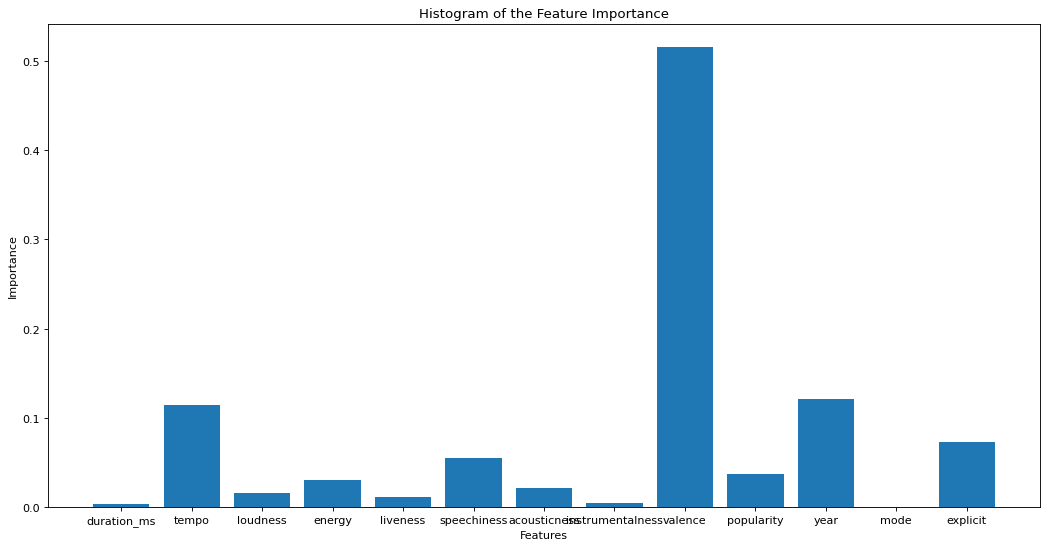

In [ ]:
fi = list(bestModel.featureImportances)
plt.figure(figsize=(16, 8), dpi=80)
plt.bar(features, fi)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Histogram of the Feature Importance')
plt.show()

On peut observer ici que les features "valence", "tempo" et "year" sont très déterminantes dans le choix de la décision. <br>
Cependant les features "mode", "duration_ms" et "instrumentalness" sont négligeables.

In [ ]:
print(bestModel.getMinInstancesPerNode())
print(bestModel.getMinInfoGain())
print(bestModel.getMaxDepth())

16
0.0001
10


In [ ]:
predictionsGridSearch = bestModel.transform(testData)
evaluatorGridSearch = RegressionEvaluator()\
  .setLabelCol("label")\
  .setPredictionCol("prediction")\
  .setMetricName("rmse")

rmseGridSearch = evaluatorGridSearch.evaluate(predictionsGridSearch)
print("Root Mean Squared Error (RMSE) on test data =", rmseGridSearch)

Root Mean Squared Error (RMSE) on test data = 0.11917626752600215


In [ ]:
evaluatorGridSearchMAE = RegressionEvaluator()\
  .setLabelCol("label")\
  .setPredictionCol("prediction")\
  .setMetricName("mae")

maeGridSearch = evaluatorGridSearchMAE.evaluate(predictionsGridSearch)
print("Mean Absolute Error (MAE) on test data =", maeGridSearch)

Mean Absolute Error (MAE) on test data = 0.09327399609741202


Je n'ai que pour deux ensembles différents de valeurs :

    Le premier :

              - .addGrid(dt.minInstancesPerNode, Array(1, 8))
              - .addGrid(dt.minInfoGain, Array(0.001, 0.005)) 
              - .addGrid(dt.maxDepth, Array(3,10)) 

    Les meilleurs paramètres pour cet ensemble sont minInstancesPerNode = 8, minInfoGain = 0.001 et maxDepth = 10 Les valeurs des métriques RMSE et MAE obtenues pour ces paramètres sont respectivement 0.127 et 0.101.
    
    Le deuxième :

              - .addGrid(dt.minInstancesPerNode, Array(8, 16))
              - .addGrid(dt.minInfoGain, Array(0.0001, 0.001)) 
              - .addGrid(dt.maxDepth, Array(10,15)) 

    Les meilleurs paramètres pour cet ensemble sont minInstancesPerNode = 16, minInfoGain = 0.0001 et maxDepth = 10 Les valeurs des métriques RMSE et MAE obtenues pour ces paramètres sont respectivement 0.119 et 0.093.

C'est donc ce deuxième ensemble qui permet d'obtenir de meilleurs résultats par rapport à notre arbre de décision normal, notamment pour les paramètres cités ci-dessus. Cela nous a permis de réduire les valeurs des RMSE et de la MAE de 0.008 toutes les deux, ce qui est non négligeable.


## Stratégie de completion de la data
On va faire ici faire la stratégie qui consiste à trier et compléter les données. On va donc identifier les données manquantes et aberrantes pour les remplacer par des valeurs calculés.

On va maintenant relancer la cross validation avec le dataset nettoyé et constater les nouvelles valeurs des métriques.


Dans un premier je n'ai gardé que les attributs qui me semblaient pertinents comme décrits au début de la stratégie de transformation des données. J'ai choisi cependant d'inclure key et d'exclure les attributs duration_ms, instrumentalness et mode.

Concernant le problème des données manquantes, j'ai choisi de remplacer une valeur nulle pour un attribut par la moyenne de l'attribut en question, au lieu de le supprimer.

Par ailleurs, pour la Cross validation, je vais prendre les hyperparamètres qui m'ont donné les meilleurs résultats.


In [ ]:
tempo_mean = spotify_df.select("tempo").agg(avg("tempo").alias("avg_tempo")).collect()
valence_mean = spotify_df.select("valence").agg(avg("valence").alias("avg_valence")).collect()
loudness_mean = spotify_df.select("loudness").agg(avg("loudness").alias("avg_loudness")).collect()
energy_mean = spotify_df.select("energy").agg(avg("energy").alias("avg_energy")).collect()
explicit_mean = spotify_df.select("explicit").agg(avg("explicit").alias("avg_explicit")).collect()
liveness_mean = spotify_df.select("liveness").agg(avg("liveness").alias("avg_liveness")).collect()
speechiness_mean = spotify_df.select("speechiness").agg(avg("speechiness").alias("avg_speechiness")).collect()
acousticness_mean = spotify_df.select("acousticness").agg(avg("acousticness").alias("avg_acousticness")).collect()
popularity_mean = spotify_df.select("popularity").agg(avg("popularity").alias("avg_popularity")).collect()
year_mean = spotify_df.select("year").agg(avg("year").alias("avg_year")).collect()
key_mean = spotify_df.select("key").agg(avg("key").alias("avg_key")).collect()
danceability_mean = spotify_df.select("danceability").agg(avg("danceability").alias("avg_danceability")).collect()

In [ ]:
avgMap = {"tempo":tempo_mean[0][0], "valence":valence_mean[0][0], 

             "loudness":loudness_mean[0][0], "energy":energy_mean[0][0],

             "explicit":explicit_mean[0][0], "liveness":liveness_mean[0][0], 

             "speechiness":speechiness_mean[0][0], "acousticness":acousticness_mean[0][0],

              "popularity":popularity_mean[0][0], "year":year_mean[0][0], 

              "key":key_mean[0][0], "danceability":danceability_mean[0][0]}
d = spotify_df.na.fill(avgMap).withColumn("label", col("danceability")).drop(col("danceability"))

In [ ]:
features = ["tempo", "valence", "loudness", "energy", "explicit", "liveness", "speechiness", "acousticness", "popularity", "key", "year"]
vecAssemb = VectorAssembler()\
        .setInputCols(features)\
        .setOutputCol("assembled")

vecIndexer = VectorIndexer()\
                .setInputCol(vecAssemb.getOutputCol())\
                .setOutputCol("features")\
                .setMaxCategories(100) 

pipeline = Pipeline().setStages([vecAssemb,vecIndexer])
transformed_data = pipeline.fit(d).transform(d)
trainingData, testData = transformed_data.randomSplit([0.7, 0.3])

dt = DecisionTreeRegressor()\
  .setLabelCol("label")\
  .setFeaturesCol("features")\
  .setMaxBins(100)

dt_paramGrid = ParamGridBuilder()\
                  .addGrid(dt.minInstancesPerNode, [8, 16])\
                  .addGrid(dt.minInfoGain, [0.0001, 0.001])\
                  .addGrid(dt.maxDepth, [10,15])\
                  .build()

cv = CrossValidator()\
            .setEstimator(dt)\
            .setEstimatorParamMaps(dt_paramGrid)\
            .setEvaluator(RegressionEvaluator())\
            .setNumFolds(3)\
            .setParallelism(2)  

cvModel = cv.fit(trainingData)
bestModel = cvModel.bestModel

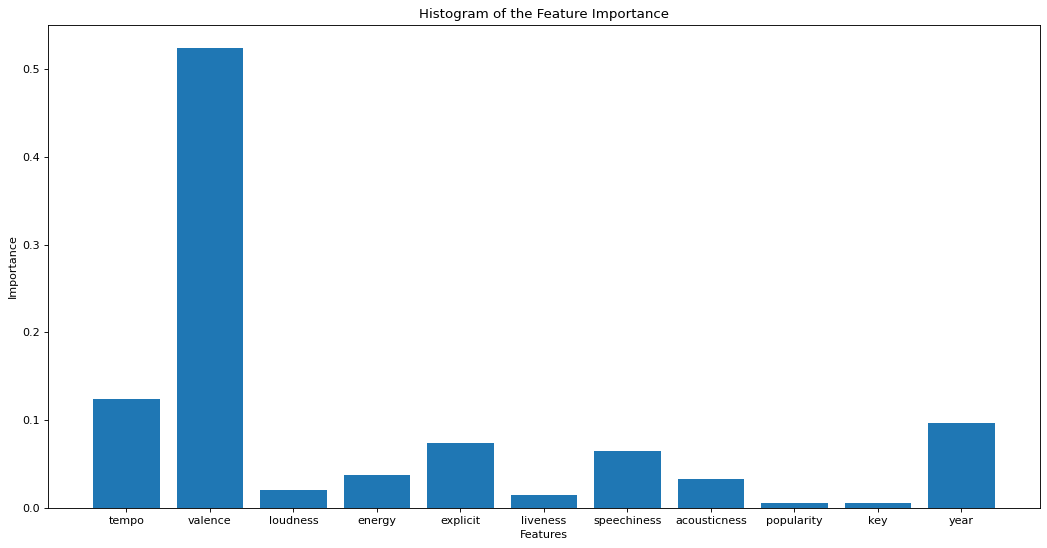

In [ ]:
fi = list(bestModel.featureImportances)
plt.figure(figsize=(16, 8), dpi=80)
plt.bar(features, fi)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Histogram of the Feature Importance')
plt.show()

On remarque ici que le vecteur de l'importance des features est similaire à celui de la stratégie précédente

In [ ]:
predictionsGridSearch = bestModel.transform(testData)

evaluatorGridSearch = RegressionEvaluator()\
  .setLabelCol("label")\
  .setPredictionCol("prediction")\
  .setMetricName("rmse")

rmseGridSearch = evaluatorGridSearch.evaluate(predictionsGridSearch)

print("Root Mean Squared Error (RMSE) on test data =", rmseGridSearch)

Root Mean Squared Error (RMSE) on test data = 0.11406147541405476


In [ ]:
evaluatorGridSearch = RegressionEvaluator()\
  .setLabelCol("label")\
  .setPredictionCol("prediction")\
  .setMetricName("mae")

mae = evaluatorGridSearch.evaluate(predictionsGridSearch)

print("Mean Absolute Error (MAE) on test data =", mae)

Mean Absolute Error (MAE) on test data = 0.08987013572340694


Les résultats que j'obtiens suite au fait d'avoir remplacé les données manquantes des attributs par la moyenne des attributs en question et d'avoir utilisé un ensemble d'attributs qui me semblaient pertinents sont meilleurs que ceux de la dernière Cross Validation précédente. En effet, j'obtiens à présent 0.114 pour la RMSE et 0.090 pour la MAE, ce qui me permet d'améliorer mes résultats.